In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


# Mnist

This is a custom made version of mnist, with 4000 images of zeros and 4000 images of ones. Their values go from 0 to 255, first thing we will do is scale them to 0-1 dividing by 255. 

tensor(0.)


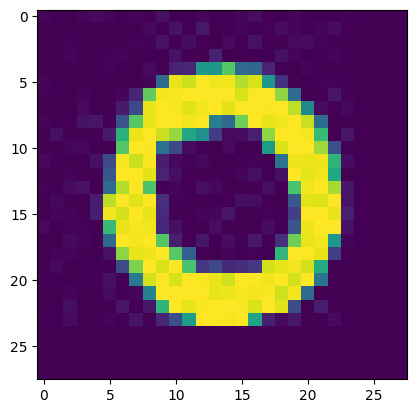

tensor(1.)


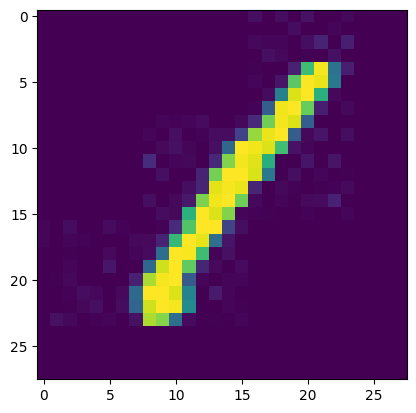

In [120]:
images = torch.load('datasets/mnist_images.pt')/255
labels = torch.load('datasets/mnist_labels.pt')

print(labels[0])
plt.imshow(images[0])
plt.show()
print(labels[4000])
plt.imshow(images[4000])
plt.show()

Now that we loaded our images, we need to flatten them to correctly use them in a neural network. Shape (784, ) is far easier to deal with than (28, 28)

In [122]:
images = images.view(-1, 28*28)

# Perceptron
This complex dataset requires us to use something more elaborate, we will build on logistic regression to make an architecture that can deal with this kind of data 
You can recall logistic regression having two trained parameters, m and q. Turns out that we can just scale that up for all of our input values, sum the results up and apply an activation function: 

Remember: images have size (DATASET_SIZE, 784) <br>
pred1 = images1 * m1 + q1  <br>
pred2 = images2 * m2 + q2 <br>
pred3 = images3 * m3 + q3 <br>
...  <br>
predn = imagesn * mn + qn <br>

and then we sum up preds like this:  <br>
(m1 * images1 + m2 * images2 + m3 * images3 + q3 ... mn * imagesn) + (q1 + q2 + q3 ... qn) <br>

actually it turns out that these two terms can be greatly simplified, the first is none other than a dot product (@ in python) and the sum of qs can be reduced to a single q value that holds the same information

The simplified formula for the perceptron is the following (without activation): <br>
**pred = images @ m + q**

In [142]:
# Parameters
m = torch.zeros(784).requires_grad_()
q = torch.zeros(1).requires_grad_()

# Training hyperparameters 
epochs = 50
lr = 1e-3

# Training loop
for epoch in range(epochs):
    # Forward pass
    pred = F.sigmoid(images @ m + q)  # formula for perceptron with sigmoid activation
    loss = F.mse_loss(pred, labels)

    # Backward pass
    loss.backward()
    with torch.no_grad():
        m -= lr * m.grad
        q -= lr * q.grad
        m.grad = None
        q.grad = None
    
    # Print loss every 10% of epochs
    if epoch % (epochs//10) == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - Accuracy: {round(((pred.round() == labels).sum().item()/len(labels))*100)}%')

Epoch 0/50 - Loss: 0.25 - Accuracy: 50%
Epoch 5/50 - Loss: 0.24567149579524994 - Accuracy: 98%
Epoch 10/50 - Loss: 0.24146634340286255 - Accuracy: 98%
Epoch 15/50 - Loss: 0.23738278448581696 - Accuracy: 98%
Epoch 20/50 - Loss: 0.2334185242652893 - Accuracy: 98%
Epoch 25/50 - Loss: 0.2295708805322647 - Accuracy: 98%
Epoch 30/50 - Loss: 0.2258368283510208 - Accuracy: 98%
Epoch 35/50 - Loss: 0.22221313416957855 - Accuracy: 98%
Epoch 40/50 - Loss: 0.21869638562202454 - Accuracy: 98%
Epoch 45/50 - Loss: 0.21528299152851105 - Accuracy: 99%


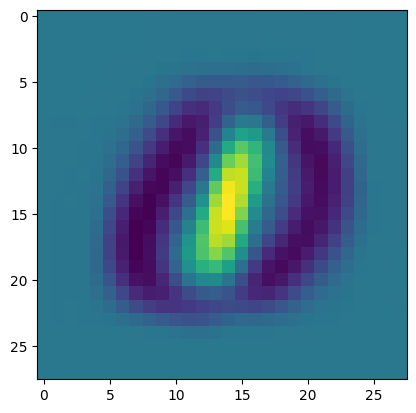

In [143]:
# Don't believe me? take a look at the trained weights 
plt.imshow(m.view(28, 28).detach().numpy())

# Loading in batches 

This is taking a while, we cant train like this... Doing a forward and backward pass on the complete dataset is slow, let's see if we can make more approximate step that's good enough by using a subset of our data in each epoch

In [144]:
m = torch.zeros(784).requires_grad_()
q = torch.zeros(1).requires_grad_()

epochs = 50
lr = 1e-3
batch_size = 1024  # taking a batch of 1024 samples at a time instead of 8000

for epoch in range(epochs):
    indexes = torch.randint(0, images.shape[0], (batch_size,))  # generating random indexes of size (batch_size,)

    pred = F.sigmoid(images[indexes] @ m + q)
    loss = F.mse_loss(pred, labels[indexes])
    loss.backward()

    with torch.no_grad():
        m -= lr * m.grad
        q -= lr * q.grad
        m.grad = None
        q.grad = None
    
    if epoch % (epochs//10) == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - Accuracy: {round(((pred.round() == labels[indexes]).sum().item()/len(labels[indexes]))*100)}%')

Epoch 0/50 - Loss: 0.25 - Accuracy: 50%
Epoch 5/50 - Loss: 0.24562427401542664 - Accuracy: 99%
Epoch 10/50 - Loss: 0.2415609061717987 - Accuracy: 98%
Epoch 15/50 - Loss: 0.23761485517024994 - Accuracy: 98%
Epoch 20/50 - Loss: 0.2331584244966507 - Accuracy: 98%
Epoch 25/50 - Loss: 0.23003123700618744 - Accuracy: 99%
Epoch 30/50 - Loss: 0.22600208222866058 - Accuracy: 98%
Epoch 35/50 - Loss: 0.222751647233963 - Accuracy: 99%
Epoch 40/50 - Loss: 0.21978768706321716 - Accuracy: 99%
Epoch 45/50 - Loss: 0.21560728549957275 - Accuracy: 99%


This is cool, we can achieve an even better loss of the previous approach at epoch 1500, and we can keep training for more epochs in the same amount of time. <br>

But some problems are way harder and can't be tackled with a solution this simple... <br>

Remember what we did earlier? We made our logistic regressor wider to make a Perceptron, now we can try expanding the perceptron in the forward direction <br>

This architecture should resemble a network of biological neurons (don't quote me on that, it's not entirely true), this is called Multi Layer Perceptron

# MLP



In [145]:
hidden_size = 128

w1 = torch.zeros(784, hidden_size).requires_grad_()
b1 = torch.zeros(hidden_size).requires_grad_()
w2 = torch.zeros(hidden_size).requires_grad_()
b2 = torch.zeros(1).requires_grad_()

epochs = 50
lr = 1e-3
batch_size = 1024
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, images.shape[0], (batch_size,))
    
    h1 = F.gelu(images[indexes] @ w1 + b1)  # We are using GELU activation function (Look at Regression.ipynb for more details)
    pred = F.sigmoid(h1 @ w2 + b2)
    loss = F.mse_loss(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()

    with torch.no_grad():
        for p in [w1, b1, w2, b2]:  # More compact way of updating many parameters
            p -= lr * p.grad
            p.grad = None

    if epoch % (epochs//10) == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - Accuracy: {round(((pred.round() == labels[indexes]).sum().item()/len(labels[indexes]))*100)}%')


Epoch 0/50 - Loss: 0.25 - Accuracy: 49%
Epoch 5/50 - Loss: 0.2499992400407791 - Accuracy: 50%
Epoch 10/50 - Loss: 0.25000450015068054 - Accuracy: 48%
Epoch 15/50 - Loss: 0.2500007152557373 - Accuracy: 50%
Epoch 20/50 - Loss: 0.2500028610229492 - Accuracy: 49%
Epoch 25/50 - Loss: 0.25000229477882385 - Accuracy: 48%
Epoch 30/50 - Loss: 0.2500040531158447 - Accuracy: 48%
Epoch 35/50 - Loss: 0.2499977946281433 - Accuracy: 51%
Epoch 40/50 - Loss: 0.25000134110450745 - Accuracy: 49%
Epoch 45/50 - Loss: 0.25 - Accuracy: 50%


In [131]:
# make a single forward pass 
indexes = torch.randint(0, images.shape[0], (batch_size,))
h1 = F.gelu(images[indexes] @ w1 + b1)  
pred = F.sigmoid(h1 @ w2 + b2)
loss = F.mse_loss(pred, labels[indexes])
loss.backward()

# Print the gradients of the weights
print(w1.grad)
print(w2.grad)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


The model is clearly stuck and cant learn. 

if we take a look at w1 gradient and w2 gradient, they are exactly zero. This happens because with weights starting at zero they cant propagate through multiple layers. 
Let's try initializing them with randn 

In [179]:
hidden_size = 128

w1 = torch.randn(784, hidden_size).requires_grad_()
b1 = torch.randn(hidden_size).requires_grad_()
w2 = torch.randn(hidden_size).requires_grad_()
b2 = torch.randn(1).requires_grad_()

epochs = 1000 # Increased num of epochs
lr = 1e-2  # Increased learning rate
batch_size = 512
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, images.shape[0], (batch_size,))
    
    h1 = F.gelu(images[indexes] @ w1 + b1) 
    pred = F.sigmoid(h1 @ w2 + b2)
    loss = F.mse_loss(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()

    with torch.no_grad():
        for p in [w1, b1, w2, b2]:  
            p -= lr * p.grad
            p.grad = None

    if epoch % (epochs//10) == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - Accuracy: {round(((pred.round() == labels[indexes]).sum().item()/len(labels[indexes]))*100)}%')


Epoch 0/1000 - Loss: 0.6777045726776123 - Accuracy: 31%
Epoch 100/1000 - Loss: 0.5323553085327148 - Accuracy: 46%
Epoch 200/1000 - Loss: 0.4880705773830414 - Accuracy: 51%
Epoch 300/1000 - Loss: 0.4771583080291748 - Accuracy: 51%
Epoch 400/1000 - Loss: 0.47213444113731384 - Accuracy: 52%
Epoch 500/1000 - Loss: 0.4267946183681488 - Accuracy: 56%
Epoch 600/1000 - Loss: 0.30634188652038574 - Accuracy: 68%
Epoch 700/1000 - Loss: 0.18283089995384216 - Accuracy: 81%
Epoch 800/1000 - Loss: 0.14657124876976013 - Accuracy: 85%
Epoch 900/1000 - Loss: 0.09192890673875809 - Accuracy: 90%


The big model is very slow to converge, this is happening once again because of the initialization, we've seen that: 
- Initializing weights at zero doesnt work with more than one layer
- Initializing weights at randn makes convergence very slow

The best solution is in the middle. There are many ways of initializing layers but we'll start with one called xavier Initialization, which starts with randn and divides the value by the square root of the number of output values 

# What's a dot product
Yes, we came up with the perceptron as a scaled up logistic regressor, but the dot product has a deeper meaning in linear algebra. 
This is the other formula for the dot product: |u||v|cosθ. <br>
Intrinsically in the dot product is the cos of the angle between the vectors, representing their similarity. It stands to reason that a set of ms correctly trained to recognize zeros, should have high similarity with zeros and low with ones.  

Let's say we have three vectors: <br>
a = [0, 1, 2] <br>
b = [2, 0, 0] <br>
c = [0, 2, 4] <br>


| Equation       | Similarity  | Angle  | Explanation                           |
|----------------|-------------|--------|---------------------------------------|
| a @ a = 5      | High        | 0°     | High similarity because the angle is zero |
| a @ -a = -5    | Opposite    | 180°   | Opposite similarity because the angle is 180° |
| a @ b = 0      | Zero        | 90°    | Zero similarity because the angle between them is 90° |
| a @ c = 10     | Really High | 0°     | Really high similarity because of zero angle and high values |


In [215]:
hidden_size = 128

# Xavier initialization
w1 = torch.randn(784, hidden_size) * (6**0.5 / (784 + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size) * (6**0.5 / (hidden_size)**0.5)
b2 = torch.zeros(1)

for p in [w1, b1, w2, b2]:
    p.requires_grad_()

epochs = 500
lr = 1e-3     # Back to previous LR
batch_size = 512
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, images.shape[0], (batch_size,))
    
    h1 = F.gelu(images[indexes] @ w1 + b1)  
    pred = F.sigmoid(h1 @ w2 + b2)
    loss = F.mse_loss(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()

    with torch.no_grad():
        for p in [w1, b1, w2, b2]:  
            p -= lr * p.grad
            p.grad = None

    if epoch % (epochs//10) == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - Accuracy: {round(((pred.round() == labels[indexes]).sum().item()/len(labels[indexes]))*100)}%')


Epoch 0/500 - Loss: 0.3109918236732483 - Accuracy: 37%
Epoch 50/500 - Loss: 0.2359813004732132 - Accuracy: 58%
Epoch 100/500 - Loss: 0.18917745351791382 - Accuracy: 71%
Epoch 150/500 - Loss: 0.14419269561767578 - Accuracy: 84%
Epoch 200/500 - Loss: 0.11713333427906036 - Accuracy: 92%
Epoch 250/500 - Loss: 0.09568268805742264 - Accuracy: 96%
Epoch 300/500 - Loss: 0.08826965093612671 - Accuracy: 96%
Epoch 350/500 - Loss: 0.0717763900756836 - Accuracy: 98%
Epoch 400/500 - Loss: 0.06375517696142197 - Accuracy: 98%
Epoch 450/500 - Loss: 0.056882355362176895 - Accuracy: 99%


Prediction: 0.7893480062484741 - Label: 1.0


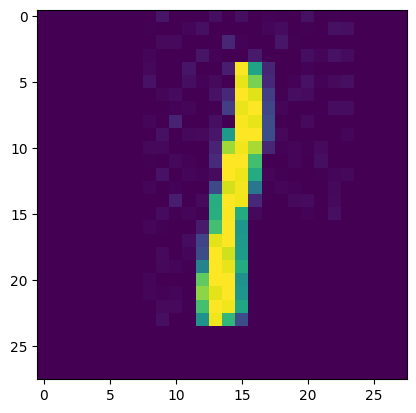

Prediction: 0.7941249012947083 - Label: 1.0


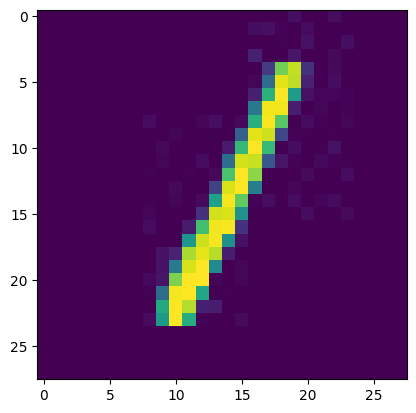

Prediction: 0.7818225622177124 - Label: 1.0


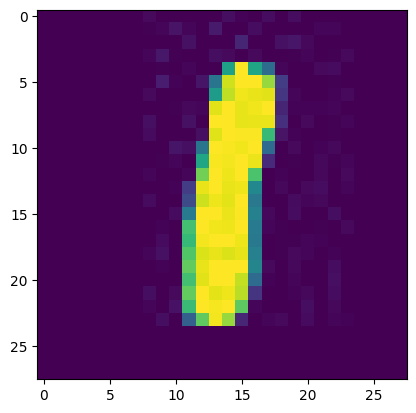

Prediction: 0.05855805426836014 - Label: 0.0


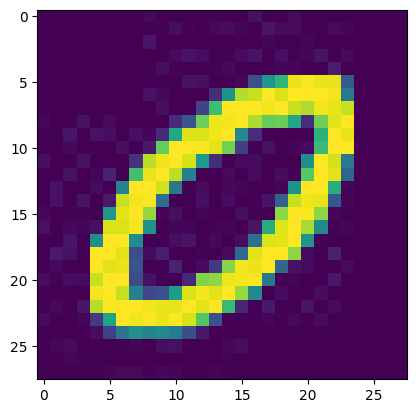

Prediction: 0.15985140204429626 - Label: 0.0


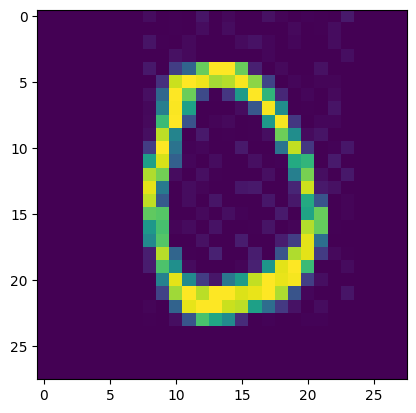

In [216]:
# Lets take a look at some predictions for fun
for i in range(5):
    print(f'Prediction: {pred[i].item()} - Label: {labels[indexes][i].item()}')
    plt.imshow(images[indexes][i].view(28, 28))
    plt.show()


# 10 Classes

Converting our loop to deal with 10 classes will be rather easy, just expand the last weights and biases to have 10 outputs

In [218]:
images = torch.load('datasets/mnist_images_10.pt')/255
labels = torch.load('datasets/mnist_labels_10.pt')

images = images.view(-1, 28*28)

In [219]:
# let's take a look at 10 random labels

random_indexes = torch.randint(0, images.shape[0], (10,))
print(labels[random_indexes]) 
# we cant train on this, we need a different 0-1 label for each class

labels = F.one_hot(labels.long(), 10).float()
print(labels[random_indexes])
# This is the one-hot encoding of the labels (simplest form of embedding)
# In which we have a 1 at the index of the class and 0s everywhere else

tensor([6., 6., 3., 8., 2., 4., 2., 1., 7., 8.])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [252]:
hidden_size = 128

w1 = torch.randn(784, hidden_size) * (6**0.5 / (784 + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, 10) * (6**0.5 / (hidden_size)**0.5)
b2 = torch.zeros(10)

for p in [w1, b1, w2, b2]:
    p.requires_grad_()

epochs = 2500  # Increased num of epochs
lr = 1e-3
batch_size = 512
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, images.shape[0], (batch_size,))
    
    h1 = F.gelu(images[indexes] @ w1 + b1)  
    pred = h1 @ w2 + b2  # Softmax is not needed here, as cross entropy does it internally
    loss = F.cross_entropy(h1 @ w2 + b2, labels[indexes].argmax(dim=1))  # Cross entropy is the best loss function for multi-class classification
    lossi.append(loss.item())
    loss.backward()

    with torch.no_grad():
        for p in [w1, b1, w2, b2]:  
            p -= lr * p.grad
            p.grad = None

    if epoch % (epochs//10) == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - Accuracy: {round(((pred.argmax(dim=1) == labels[indexes].argmax(dim=1)).sum().item()/len(labels[indexes]))*100)}%')

Epoch 0/2500 - Loss: 2.8929316997528076 - Accuracy: 8%
Epoch 250/2500 - Loss: 1.9024730920791626 - Accuracy: 37%
Epoch 500/2500 - Loss: 1.557490587234497 - Accuracy: 51%
Epoch 750/2500 - Loss: 1.2810659408569336 - Accuracy: 63%
Epoch 1000/2500 - Loss: 1.1557146310806274 - Accuracy: 67%
Epoch 1250/2500 - Loss: 0.998669445514679 - Accuracy: 74%
Epoch 1500/2500 - Loss: 0.9191227555274963 - Accuracy: 75%
Epoch 1750/2500 - Loss: 0.9014284014701843 - Accuracy: 75%
Epoch 2000/2500 - Loss: 0.81950443983078 - Accuracy: 77%
Epoch 2250/2500 - Loss: 0.7044917345046997 - Accuracy: 79%


This isnt working right. Let's look at some predictions

Prediction: 5 - Confidence 63.30% - Label: 5


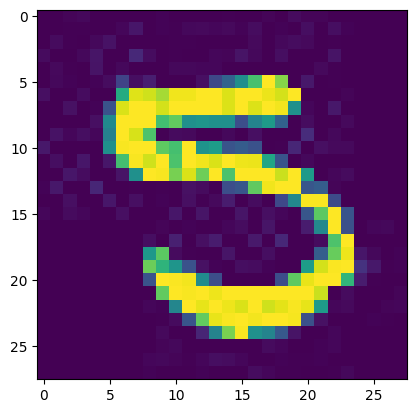

Prediction: 8 - Confidence 56.10% - Label: 8


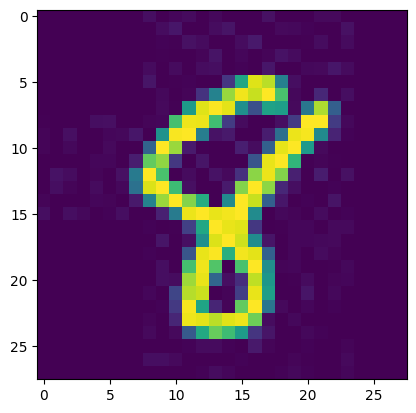

Prediction: 3 - Confidence 52.10% - Label: 3


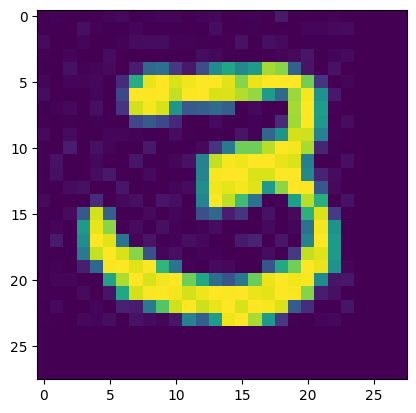

Prediction: 0 - Confidence 91.40% - Label: 0


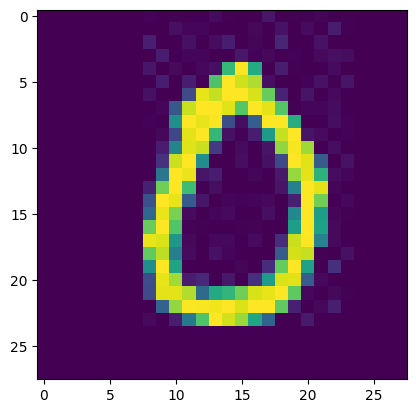

Prediction: 3 - Confidence 89.50% - Label: 3


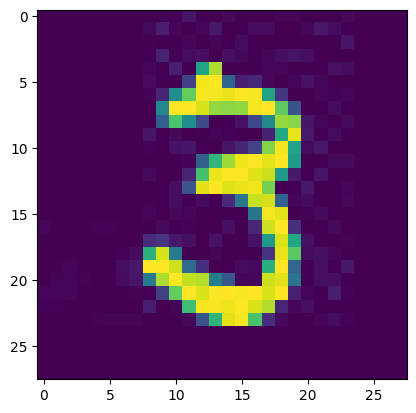

In [266]:
# Lets take a look at some predictions for fun

for i in range(5):
    print(f'Prediction: {pred[i].argmax()} - Confidence {round(pred.softmax(-1)[i, (pred[i]).argmax()].item(), 3)*100:.2f}% - Label: {labels[indexes][i].argmax().item()}')
    plt.imshow(images[indexes][i].view(28, 28))
    plt.show()
